In [4]:
from mimic.utilities import *

from mimic.model_infer.infer_CRM_bayes import *
from mimic.model_infer import *
from mimic.model_simulate import *
from mimic.model_simulate.sim_gLV import *


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as at
import pickle
import cloudpickle

### Import *Clare et al* time series data

In [5]:
# Import and format the data

def get_data(input_data):
    # Read the CSV file
    d = pd.read_csv(input_data)

    # Adjust for data size and number of species as necessary
    # Take only time course up to t=400
    X1_bar = d.iloc[1:38, 1:9].mean(axis=1)

    # Calculate the mean of the second species
    X2_bar = d.iloc[1:38, 9:18].mean(axis=1)

    # Combine the first column with the calculated means
    obs = pd.DataFrame({
        'time': d.iloc[1:38, 0],
        'X1_bar': X1_bar,
        'X2_bar': X2_bar
    })

    # Replace negative values with 0
    obs[obs < 0] = 0

    return obs

    


def get_data_m(input_data):
    # Read the CSV file
    d = pd.read_csv(input_data)

    # Adjust for data size and number of species as necessary
    # Take only time course up to t=400
    X1_bar = d.iloc[1:38, 1:5].mean(axis=1)

    # Combine the first column with the calculated means
    obs = pd.DataFrame({
        'time': d.iloc[1:38, 0],
        'X1_bar': X1_bar,
    })

    # Replace negative values with 0
    obs[obs < 0] = 0

    return obs


# Define the base directory
base_path = '/Users/chaniaclare/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Documents/PhD/Barnes-PhD/Co-cultures/plate_reader/240823_EcN_Sent_Bsub_co/fitting/'

# Import co-culture data
EcN_Sent_glu = get_data(base_path + "EcN_Sent_glu_co.csv")
EcN_Sent_EAB12 = get_data(base_path + "EcN_Sent_EAB12_co.csv")
EcN_Sent_EAB12glu = get_data(base_path + "EcN_Sent_EAB12glu_co.csv")

# Import monoculture data
EcN_glu = get_data_m(base_path + "EcN_glu_mono.csv")
EcN_EAB12 = get_data_m(base_path + "EcN_EAB12_mono.csv")
EcN_EAB12glu = get_data_m(base_path + "EcN_EAB12glu_mono.csv")

Sent_glu = get_data_m(base_path + "Sent_glu_mono.csv")
Sent_EAB12 = get_data_m(base_path + "Sent_EAB12_mono.csv")
Sent_EAB12glu = get_data_m(base_path + "Sent_EAB12glu_mono.csv")

all_data = pd.concat([EcN_Sent_glu.iloc[:, 0:3], EcN_Sent_EAB12.iloc[:, 1:3], EcN_Sent_EAB12glu.iloc[:, 1:3], 
                      EcN_glu.iloc[:, 1], EcN_EAB12.iloc[:, 1], EcN_EAB12glu.iloc[:, 1],
                      Sent_glu.iloc[:, 1], Sent_EAB12.iloc[:, 1], Sent_EAB12glu.iloc[:, 1]], axis=1)




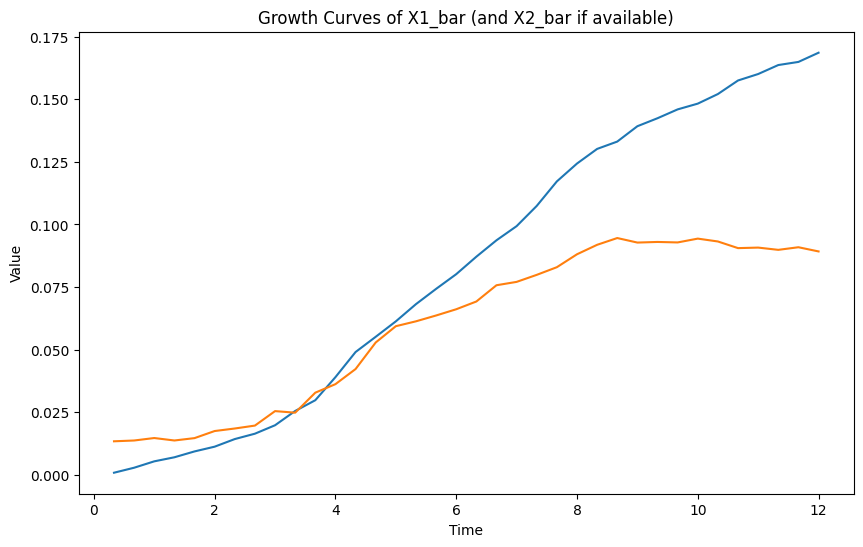

In [6]:
plot_growth_curves(EcN_Sent_EAB12)

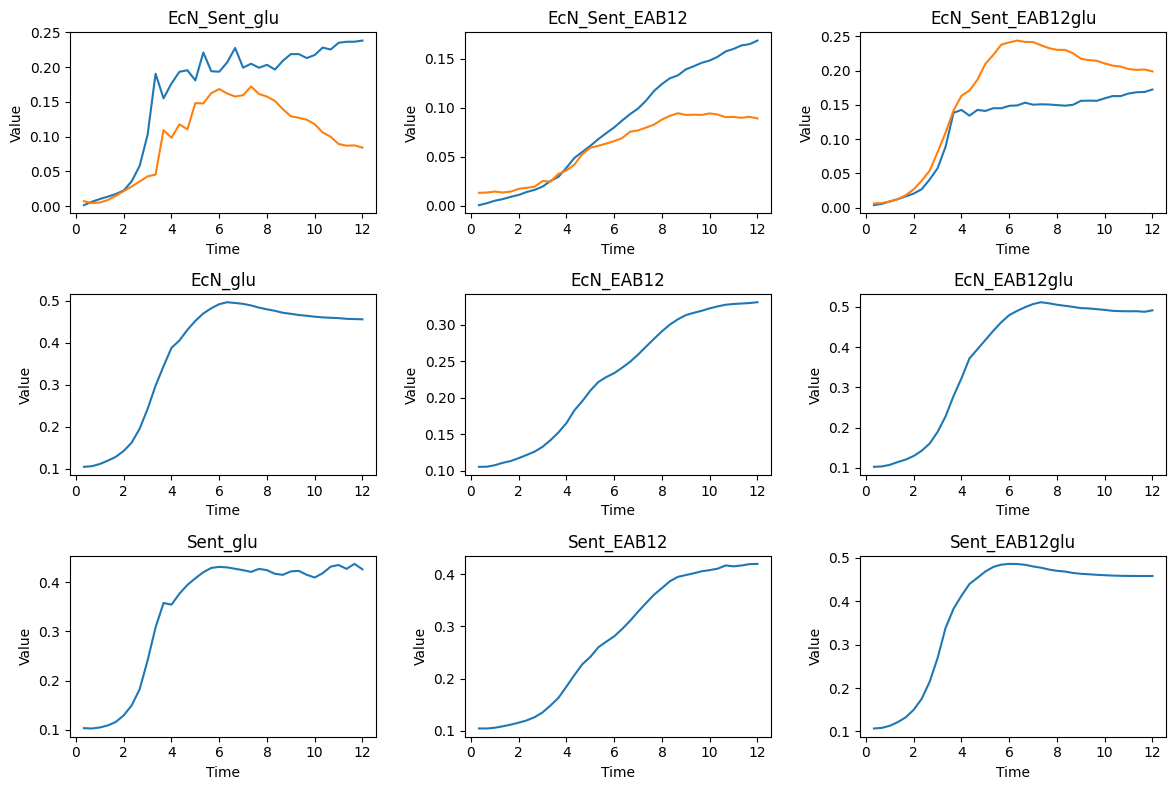

In [7]:
import matplotlib.pyplot as plt

## Plot the growth curves for all conditions

# Define the condition names
conditions = ['EcN_Sent_glu', 'EcN_Sent_EAB12', 'EcN_Sent_EAB12glu', 
              'EcN_glu', 'EcN_EAB12', 'EcN_EAB12glu', 
              'Sent_glu', 'Sent_EAB12', 'Sent_EAB12glu']

# Link the condition names to their data
data_dict = {
    'EcN_Sent_glu': EcN_Sent_glu,
    'EcN_Sent_EAB12': EcN_Sent_EAB12,
    'EcN_Sent_EAB12glu': EcN_Sent_EAB12glu,
    'EcN_glu': EcN_glu,
    'EcN_EAB12': EcN_EAB12,
    'EcN_EAB12glu': EcN_EAB12glu,
    'Sent_glu': Sent_glu,
    'Sent_EAB12': Sent_EAB12,
    'Sent_EAB12glu': Sent_EAB12glu
}

# Create a facet plot
fig, axes = plt.subplots(3, 3, figsize=(12,8))

axes = axes.flatten()

for i, condition in enumerate(conditions):
    data = data_dict[condition] 
    plot_growth_curves(data, axes[i]) 
    axes[i].set_title(condition)

plt.tight_layout()
plt.show()



In [8]:
# Extract data and convert to numpyarrays

yobsdf = EcN_Sent_EAB12.iloc[:, [1,2]]
yobs = yobsdf.to_numpy()
timesa = EcN_Sent_EAB12.iloc[:, 0]
times = timesa.to_numpy()

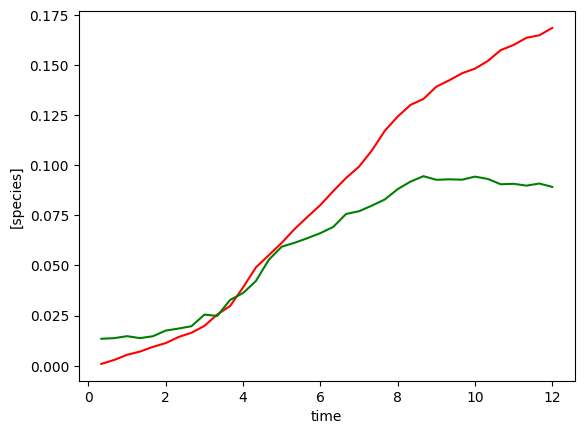

In [9]:
plot_gLV(yobs, times)

In [10]:
X, F = linearize_time_course_16S(yobs, times)

### Define symbolic and numerical ODEs for CRM model

In [11]:
import numpy as np
import pymc as pm
from pymc.ode import DifferentialEquation

# Define the ODE function for CRM model
def CRM(y,t, p):
    # Unpack parameters from the vector p
    nr = p[0].astype("int32")   # Number of resources
    nsp = p[1].astype("int32")   # Number of species
    tau = p[2:2+nsp]  # Species time scales
    w = p[2+nsp:2+nsp+nr]  # Resource quality
    c_flat = p[2+nsp+nr:2+nsp+nr+(nsp*nr)]  # Flattened resource preferences
    c = c_flat.reshape((nsp, nr))  # Reshape to nsp x nr matrix
    m = p[2+nsp+nr+(nsp*nr):2+(2*nsp)+nr+(nsp*nr)]  # Mortality rates
    r = p[2+(2*nsp)+nr+(nsp*nr):2+(2*nsp)+(2*nr)+(nsp*nr)]  # Resource time scales
    K = p[2+(2*nsp)+(2*nr)+(nsp*nr):2+(2*nsp)+(3*nr)+(nsp*nr)]  # Resource carrying capacities

    # tau = p[:2]  # Species time scales 
    # w = p[2:4]  # Resource quality 
    # c_flat = p[4:8]  # Flattened resource preferences 
    # c = c_flat.reshape((2, 2))  # Reshape to 2x2 matrix
    # m = p[8:10]  # Mortality rates 
    # r = p[10:12]  # Resource time scales 
    # K = p[12:14]  # Resource carrying capacities

    # Separate species (N) and resources (R)
    N = y[:nsp]  # Species populations 
    R = y[nsp:]  # Resource availability 

    
    # Species growth equation (dN)
    growth_term = at.dot(c, w * R)  # Matrix multiplication for species-resource interaction as tensor
    dN = (N / tau) * (growth_term - m)  # Species growth equation

    # Resource consumption equation (dR)
    consumption_term = at.dot(N, c)  # Matrix multiplication for resource consumption by species as tensor
    dR = (1 / (r * K)) * (K - R) * R - consumption_term * R  # Resource consumption equation

    # Combine dN and dR into a single 1D array
    derivatives = [dN[0], dN[1], dR[0], dR[1]]  # Horizontal stacking ensures a 1D array
   
    # Return the derivatives for both species and resources as a single array
    return derivatives  

def CRM_numeric(y,t, p):
    # Unpack parameters from the vector p
    nr = p[0]  # Number of resources
    nsp = p[1]  # Number of species
    tau = p[2:2+nsp]  # Species time scales
    w = p[2+nsp:2+nsp+nr]  # Resource quality
    c_flat = p[2+nsp+nr:2+nsp+nr+(nsp*nr)]  # Flattened resource preferences
    c = c_flat.reshape((nsp, nr))  # Reshape to nsp x nr matrix
    m = p[2+nsp+nr+(nsp*nr):2+(2*nsp)+nr+(nsp*nr)]  # Mortality rates
    r = p[2+(2*nsp)+nr+(nsp*nr):2+(2*nsp)+(2*nr)+(nsp*nr)]  # Resource time scales
    K = p[2+(2*nsp)+(2*nr)+(nsp*nr):2+(2*nsp)+(3*nr)+(nsp*nr)]  # Resource carrying capacities

    # tau = p[:2]  # Species time scales 
    # w = p[2:4]  # Resource quality 
    # c_flat = p[4:8]  # Flattened resource preferences 
    # c = c_flat.reshape((2, 2))  # Reshape to 2x2 matrix
    # m = p[8:10]  # Mortality rates 
    # r = p[10:12]  # Resource time scales 
    # K = p[12:14]  # Resource carrying capacities

    # Separate species (N) and resources (R)
    N = y[:nsp]  # Species populations 
    R = y[nsp:]  # Resource availability 


    # Species growth equation (dN)
    growth_term = np.dot(c, w * R)  # Matrix multiplication for species-resource interaction
    dN = (N / tau) * (growth_term - m)  # Species growth equation

    # Resource consumption equation (dR)
    consumption_term = np.dot(N, c)  # Matrix multiplication for resource consumption by species
    dR = (1 / (r * K)) * (K - R) * R - consumption_term * R  # Resource consumption equation

    # Combine dN and dR into a single 1D array
    derivatives = [dN[0], dN[1], dR[0], dR[1]]  # Horizontal stacking ensures a 1D array
   

    # Return the derivatives for both species and resources as a single array
    return derivatives  




### Define DifferentialEquation model with pymc

In [21]:
# Set up initial conditions and parameters
nsp = 2
nr = 2
n_states = nsp + nr
n_theta = 2 + (2 * nsp) + (3 * nr) + (nsp * nr)

# Time points for integration
times = times

# Define the DifferentialEquation model
crm_model = DifferentialEquation(
    func=CRM,  # The ODE function
    times=times,  # Time points for the solution
    n_states=n_states,  # Total state variables (nsp + nr)
    n_theta=n_theta,  # Total number of parameters (2 + tau, w, c, m, r, K)
    t0=0  # Initial time
)


### Perform Bayesian inference and plot parameter values

Only 20 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Adjusted crm_species_curves shape: [35  2]
F shape: (35, 2)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, tau, w, c, m, r, K]


Output()

/Users/chaniaclare/Documents/GitHub/MIMIC/venv/lib/python3.10/site-packages/pymc/ode/ode.py:133: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


/Users/chaniaclare/Documents/GitHub/MIMIC/venv/lib/python3.10/site-packages/pymc/ode/ode.py:133: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


Sampling 2 chains for 20 tune and 20 draw iterations (40 + 40 draws total) took 1279 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.
Sampling: [Y]


Output()

KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data)


array([[<Axes: title={'center': 'K\n0'}>,
        <Axes: title={'center': 'K\n1'}>,
        <Axes: title={'center': 'c\n0, 0'}>],
       [<Axes: title={'center': 'c\n0, 1'}>,
        <Axes: title={'center': 'c\n1, 0'}>,
        <Axes: title={'center': 'c\n1, 1'}>],
       [<Axes: title={'center': 'm\n0'}>,
        <Axes: title={'center': 'm\n1'}>,
        <Axes: title={'center': 'r\n0'}>],
       [<Axes: title={'center': 'r\n1'}>,
        <Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'tau\n0'}>],
       [<Axes: title={'center': 'tau\n1'}>,
        <Axes: title={'center': 'w\n0'}>,
        <Axes: title={'center': 'w\n1'}>]], dtype=object)

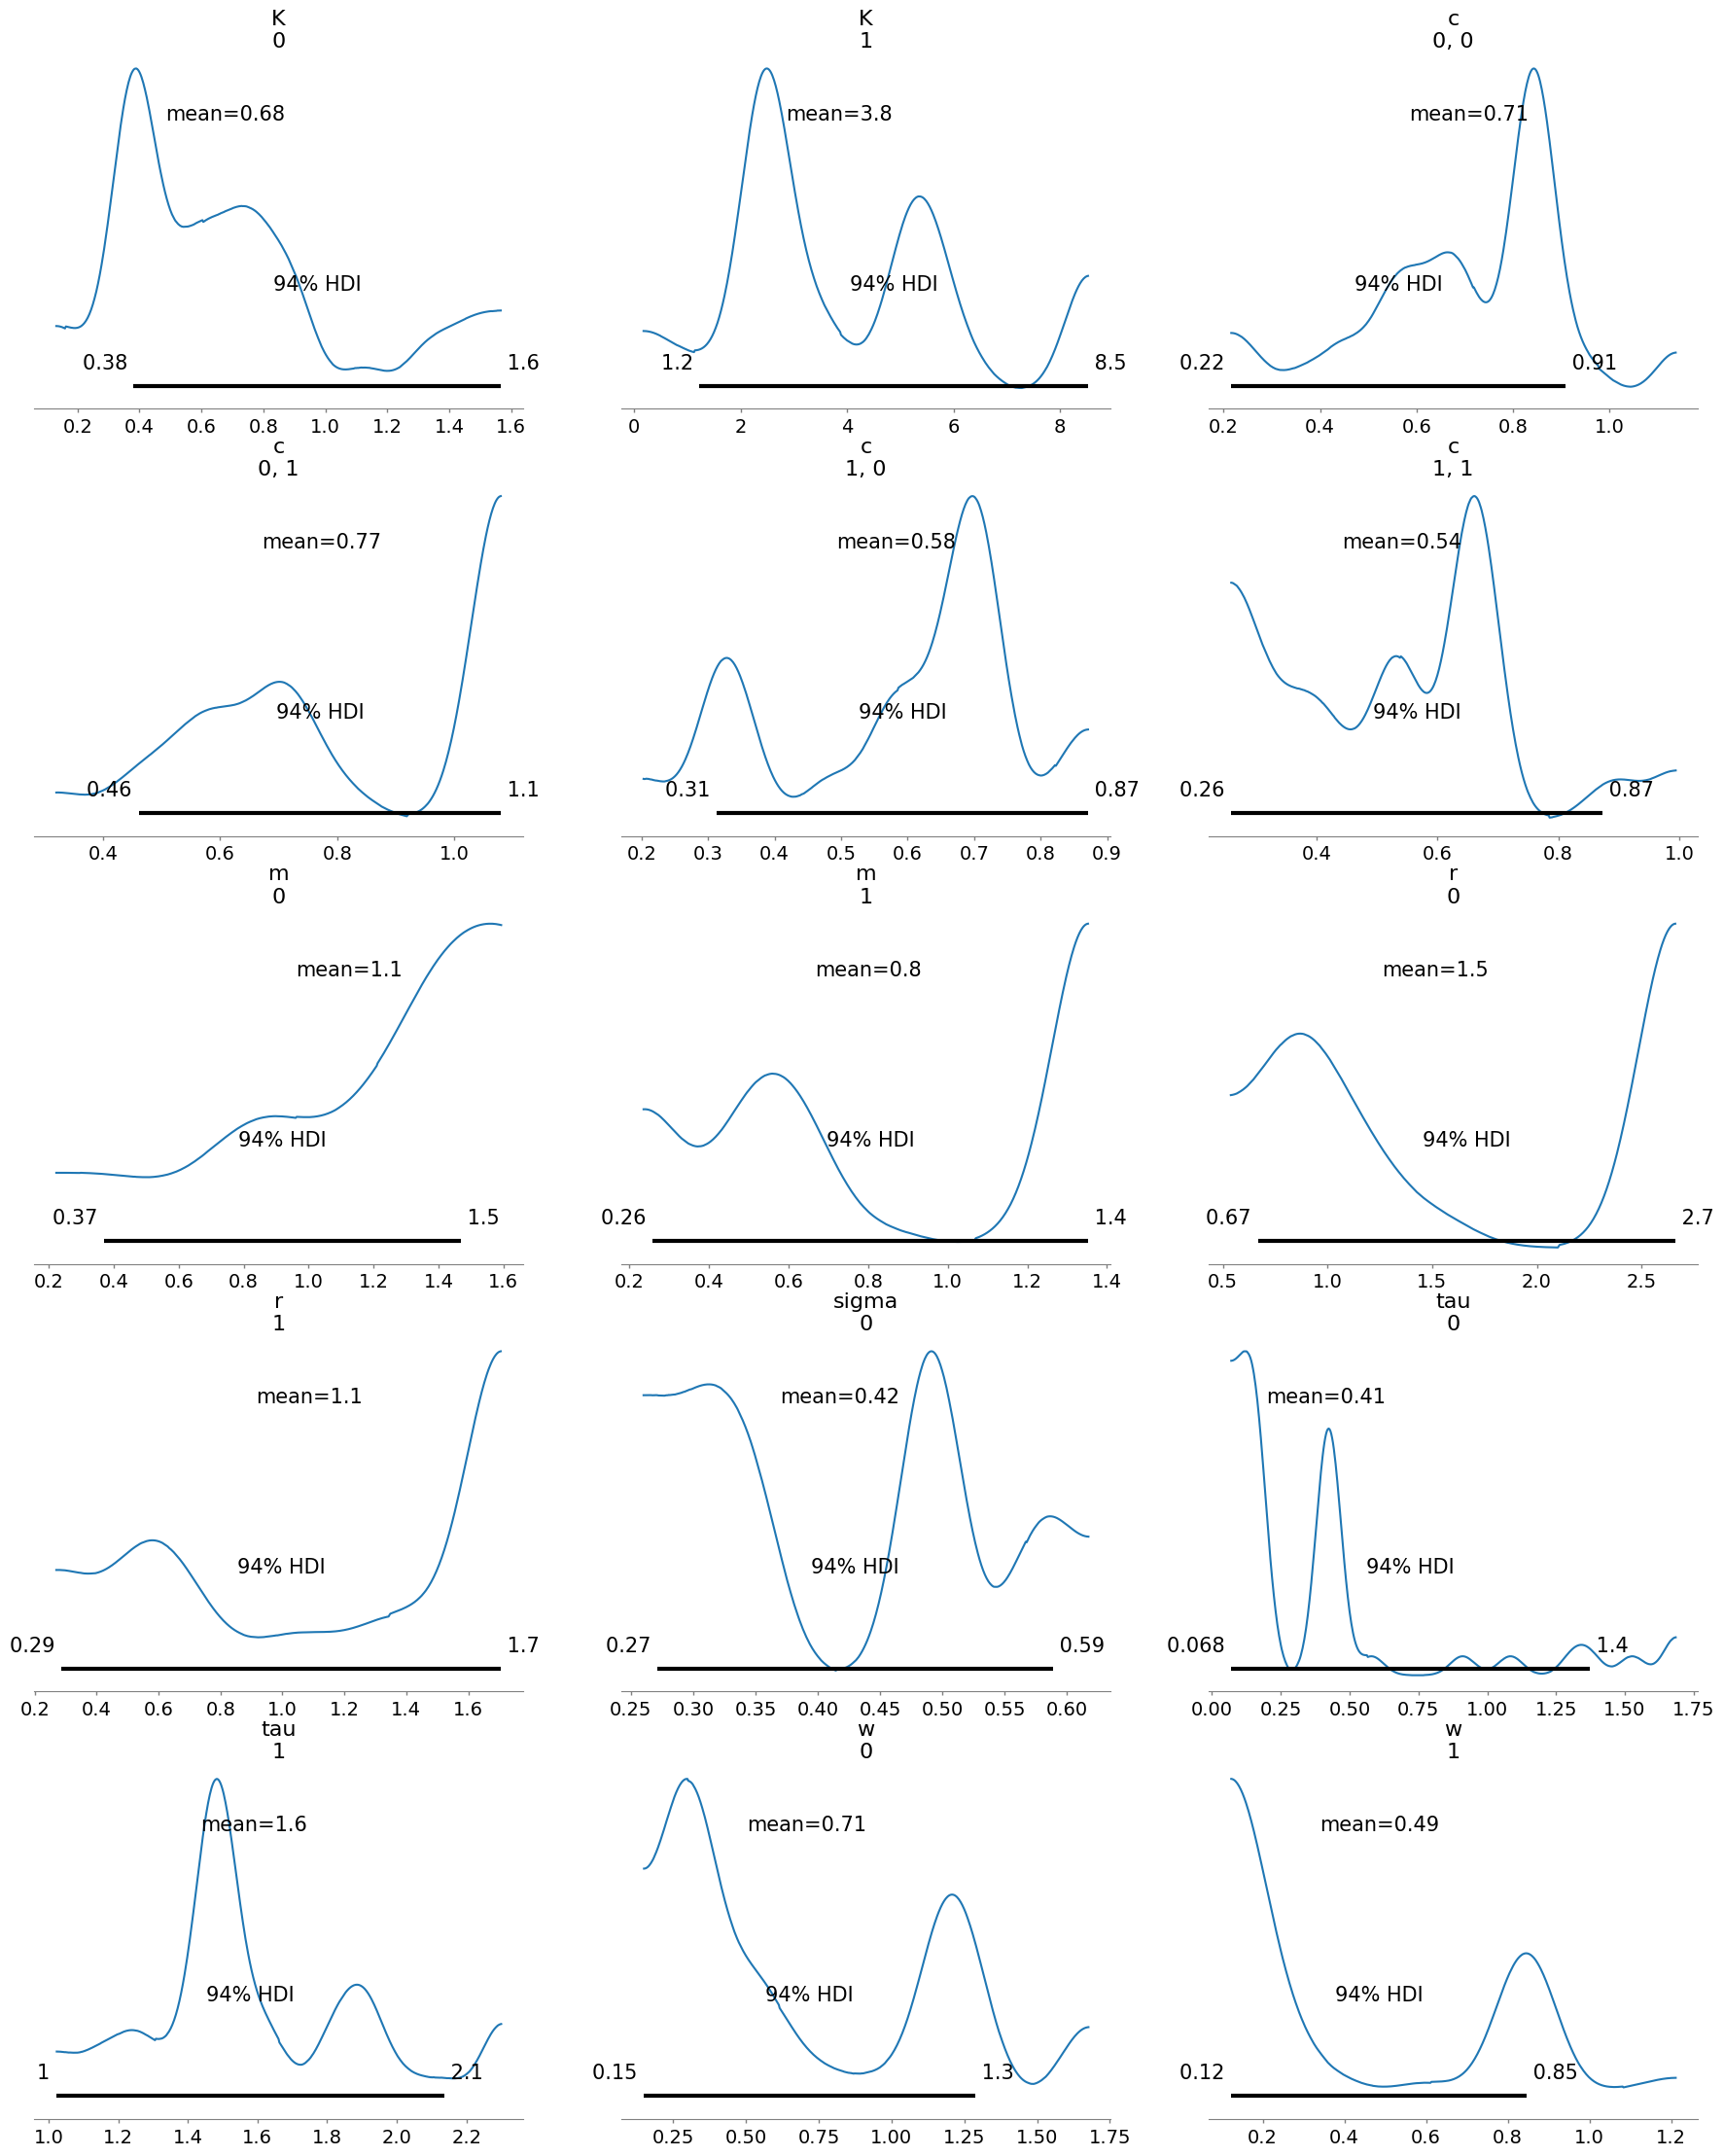

In [22]:
n_states = nsp + nr

with pm.Model() as model:
    # Priors for the parameters
    sigma = pm.HalfNormal('sigma', sigma=0.6, shape=(1,))  # Same sigma for all responses
    tau = pm.TruncatedNormal("tau", mu=1.1, sigma=0.5, lower=0, shape=nsp)  # Species time scales 
    w = pm.TruncatedNormal("w", mu=0.7, sigma=0.5, lower=0, shape=nr)   # Resource quality 
    c = pm.TruncatedNormal("c", mu=0.6, sigma=0.2, lower=0, shape=(nsp, nr))    # Resource preferences 
    m = pm.TruncatedNormal("m", mu=0.25, sigma=0.5, lower=0, shape=nsp) # Mortality rates
    r = pm.TruncatedNormal("r", mu=1.0, sigma=0.5, lower=0, shape=nr)   # Resource time scales
    K = pm.TruncatedNormal("K", mu=3.0, sigma=2.0, lower=0, shape=nr)  # Resource carrying capacities


    # Pack parameters into a single vector

    nr_tensor = at.as_tensor_variable([nr]) 
    nsp_tensor = at.as_tensor_variable([nsp])

    theta = at.concatenate([nr_tensor, nsp_tensor, tau, w, c.flatten(), m, r, K])

    # Initial conditions for the ODE
    initial_conditions = np.concatenate([(yobs[0,:]), np.array([8.0, 12.0])])
    y0 = np.concatenate([np.ones(nsp), np.ones(nr)])  # Initial species and resource populations

    # Solve the ODE
    crm_curves = crm_model(y0=initial_conditions, theta=theta)
    crm_species_curves = crm_curves[1:, :nsp]  # Extract species curves only, excluding first time point
    #print(crm_curves.eval({tau: np.ones(nsp), w: np.ones(nr), c: np.ones((nsp, nr)), m: np.ones(nsp), r: np.ones(nr), K: np.ones(nr)}))

    print("Adjusted crm_species_curves shape:", crm_species_curves.shape.eval())
    print("F shape:", F.shape)


    # Define the likelihood
    #Y = pm.Lognormal("Y", mu=at.log(crm_curves), sigma=sigma, observed=F)
    #Y = pm.Lognormal("Y", mu=pm.math.log(crm_species_curves), sigma=sigma, observed=F)
    Y = pm.Normal("Y", mu=crm_species_curves, sigma=sigma, observed=F)
    

    # Sample the posterior
    data = pm.sample(draws = 20, tune=20, chains =2, cores=2)
    posterior_predictive = pm.sample_posterior_predictive(data)
    
print(posterior_predictive.keys())

az.plot_posterior(data)

In [18]:
# Print summary

summary = az.summary(data, var_names=["tau", "w", "c", "m", "r","K", "sigma"])


print(summary[["mean", "sd", "r_hat"]])


# Save posterior samples to file
az.to_netcdf(data, 'model_posterior.nc')

arviz - WARNING - Shape validation failed: input_shape: (1, 20), minimum_shape: (chains=2, draws=4)


           mean     sd  r_hat
tau[0]    0.867  0.158    NaN
tau[1]    0.825  0.250    NaN
w[0]      1.122  0.458    NaN
w[1]      1.164  0.324    NaN
c[0, 0]   0.777  0.134    NaN
c[0, 1]   0.804  0.253    NaN
c[1, 0]   0.621  0.279    NaN
c[1, 1]   0.666  0.139    NaN
m[0]      0.630  0.127    NaN
m[1]      0.594  0.251    NaN
r[0]      1.597  0.348    NaN
r[1]      1.556  0.606    NaN
K[0]      0.827  0.479    NaN
K[1]      0.738  0.469    NaN
sigma[0]  0.276  0.020    NaN


'model_posterior.nc'

In [10]:
import arviz as az

def plot_data(ax, yobs, times, title="Observed Data"):
    """
    Plots the observed data.
    """
    ax.plot(times, yobs[:, 0], color="b", marker="o", markersize=12, label="Species 1 (Data)")
    ax.plot(times, yobs[:, 1], color="g", marker="+", markersize=14, label="Species 2 (Data)")
    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Population", fontsize=14)
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)
    return ax






In [11]:
print(posterior_predictive.keys())  # List of available groups (e.g., posterior, posterior_predictive)
print(posterior_predictive.posterior_predictive.keys())  # Variables inside posterior_predictive group


KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data)
KeysView(<xarray.Dataset> Size: 12kB
Dimensions:  (chain: 1, draw: 20, Y_dim_2: 35, Y_dim_3: 2)
Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 160B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * Y_dim_2  (Y_dim_2) int64 280B 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34
  * Y_dim_3  (Y_dim_3) int64 16B 0 1
Data variables:
    Y        (chain, draw, Y_dim_2, Y_dim_3) float64 11kB -0.4115 ... 0.7606
Attributes:
    created_at:                 2024-12-19T12:16:16.277419+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.19.1)


In [12]:
print("Observed data (yobs) stats:")
print("Min:", np.min(yobs), "Max:", np.max(yobs), "Mean:", np.mean(yobs))

print("Posterior predictive (Y_samples) stats:")
Y_samples = posterior_predictive.posterior_predictive['Y']
print("Min:", np.min(Y_samples.values), "Max:", np.max(Y_samples.values), "Mean:", np.mean(Y_samples.values))

Observed data (yobs) stats:
Min: 0.0034407660570930625 Max: 0.24375328080266298 Mean: 0.1407934027777778
Posterior predictive (Y_samples) stats:
Min: -1.5778650596806745 Max: 3.06892563846754 Mean: 0.059874086587316584


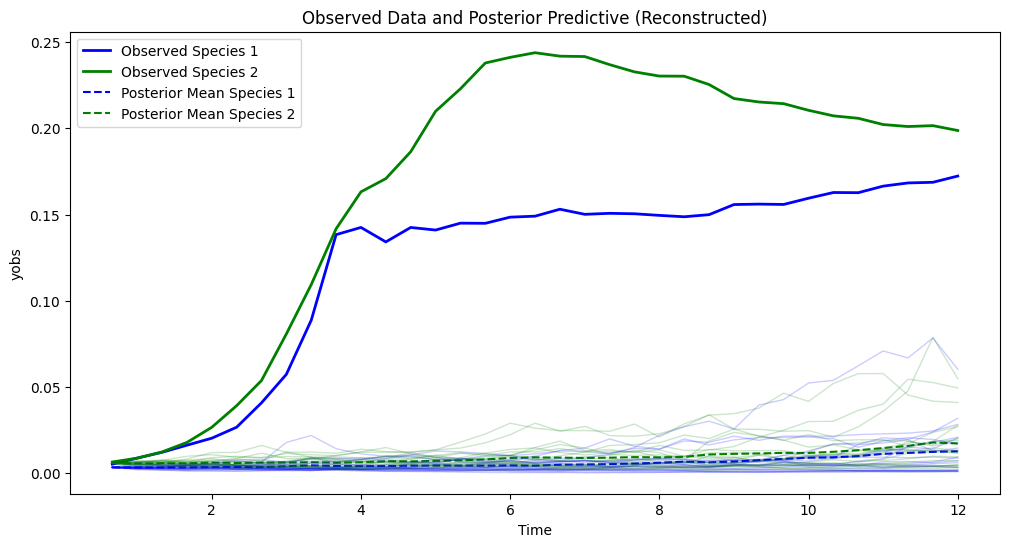

In [14]:
import numpy as np
import matplotlib.pyplot as plt

yobsa = yobs[1:,:]
timesa = times[1:]

# Back-transform posterior predictive samples to the yobs scale (after it was log-transformed and and time-differentiated to make F)
def reconstruct_y_pred(Y_samples, yobs, times):
    """
    Reconstructs y_pred from posterior predictive samples (Y_samples) using yobs[0, :] as initial conditions.
    """
    dt = np.diff(times)  # Time step differences
    initial_y = yobs[0, :]  # Initial condition: first row of yobs

    # Initialize an array to store reconstructed y_pred
    num_chains, num_draws, num_timesteps, num_species = Y_samples.shape
    y_pred = np.zeros((num_chains, num_draws, num_timesteps, num_species))

    for chain in range(num_chains):
        for draw in range(num_draws):
            # Start with the initial condition
            y_pred[chain, draw, 0, :] = initial_y

            # Iteratively reconstruct y_pred for subsequent timesteps
            for t in range(1, num_timesteps):
                y_pred[chain, draw, t, :] = (
                    y_pred[chain, draw, t - 1, :] * np.exp(Y_samples[chain, draw, t - 1, :] * dt[t - 1])
                )
    return y_pred

# Extract Y_samples and reconstruct y_pred
Y_samples = posterior_predictive.posterior_predictive["Y"].values
y_pred = reconstruct_y_pred(Y_samples, yobs, times)

# Compute mean posterior predictive trajectory for each species
mean_y_pred = np.mean(y_pred, axis=(0, 1))  # Mean over chain and draw

# Plot observed data and reconstructed posterior predictive samples
fig, ax = plt.subplots(figsize=(12, 6))

# Plot observed data
ax.plot(timesa, yobsa[:, 0], color="blue", label="Observed Species 1", lw=2)
ax.plot(timesa, yobsa[:, 1], color="green", label="Observed Species 2", lw=2)

# Plot mean posterior predictive
ax.plot(timesa, mean_y_pred[:, 0], linestyle="--", color="blue", label="Posterior Mean Species 1")
ax.plot(timesa, mean_y_pred[:, 1], linestyle="--", color="green", label="Posterior Mean Species 2")

# Plot posterior predictive samples (subset for clarity)
num_samples_to_plot = 20
for i in range(num_samples_to_plot):
    ax.plot(timesa, y_pred[0, i, :, 0], color="blue", alpha=0.2, lw=1)
    ax.plot(timesa, y_pred[0, i, :, 1], color="green", alpha=0.2, lw=1)

# Add legend and labels
ax.legend()
ax.set_title("Observed Data and Posterior Predictive (Reconstructed)")
ax.set_xlabel("Time")
ax.set_ylabel("yobs")
plt.show()


In [ ]:
num_species = 2
num_resources = 1

# Set bounds for each prior
tau_bounds = (0.1, 5)   # species timescale
r_bounds = (0.01, 2)    # resource timescale
w_bounds = (0.1, 3)     # resource quality
c_bounds = (0, 1)       # relative preferences
m_bounds = (0.01, 0.5)  # mortality rate
K_bounds = (0.5, 10)    # resource capacity

# Sampling conditions
draws = 500
tune = 500
chains = 4
cores = 4

inference = inferCRMbayes()

inference.set_parameters(X=X, F=F, num_species=num_species, num_resources=num_resources,
                          tau_bounds=tau_bounds, r_bounds=r_bounds,
                          w_bounds=w_bounds, c_bounds=c_bounds,
                          m_bounds=m_bounds, K_bounds = K_bounds,
                          draws=draws, tune=tune, chains=chains,cores=cores)

idata = inference.run_inference()

In [ ]:
tau_hat = np.random.uniform(0.1, 1.0, (num_species,1))


c_hat = np.random.uniform(0.1, 1.0, (num_species, num_resources))

m_hat = np.random.uniform(0.1, 1.0, (1,1))

print("Shape of tau_hat:", tau_hat.shape)
print("Shape of c_hat:", c_hat.shape)
print("Shape of m_hat:", m_hat.shape)

# Expected value of outcome
combined_values = pm.math.concatenate([m_hat, tau_hat], axis=0)
print("Combined values shape:", combined_values.shape.eval())

In [ ]:
from mimic.model_simulate.sim_CRM import sim_CRM

# initial conditions
init_species = 10 * np.ones(num_species+num_resources)
times = np.arange(0, 10, 0.1)

# instantiate simulator
simulator = sim_CRM(num_species=num_species,
                    num_resources=num_resources)

simulator.set_parameters(num_species = num_species,
                         num_resources = num_resources,
                         tau=idata.posterior['tau'].mean(dim='chain').values,  # Use mean across chains
                         r=idata.posterior['r'].mean(dim='chain').values,
                         w=idata.posterior['w'].mean(dim='chain').values,
                         c=idata.posterior['c'].mean(dim='chain').values,
                         m=idata.posterior['m'].mean(dim='chain').values,
                         K=idata.posterior['K'].mean(dim='chain').values)

simulator.print_parameters()

yobs, sobs = simulator.simulate(times, init_species)
 
# plot species simulation
plot_gLV(yobs, times)

# plot resources simulation
plot_gLV(sobs, times)

